# Retrieval Augmented Question & Answering with Amazon Bedrock using LangChain & Pinecone Vector DB

> *This notebook should work well with the **`Data Science 3.0` (Python 3.10)** kernel in SageMaker Studio*

### Context
Previously we saw that the model told us how to to change the tire, however we had to manually provide it with the relevant data and provide the contex ourselves. We explored the approach to leverage the model availabe under Bedrock and ask questions based on it's knowledge learned during training as well as providing manual context. While that approach works with short documents or single-ton applications, it fails to scale to enterprise level question answering where there could be large enterprise documents which cannot all be fit into the prompt sent to the model. 

### Pattern
We can improve upon this process by implementing an architecure called Retreival Augmented Generation (RAG). RAG retrieves data from outside the language model (non-parametric) and augments the prompts by adding the relevant retrieved data in context. 

In this notebook we explain how to approach the pattern of Question Answering to find and leverage the documents to provide answers to the user questions.

### Challenges
- How to manage large document(s) that exceed the token limit
- How to find the document(s) relevant to the question being asked

### Proposal
To the above challenges, this notebook proposes the following strategy
#### Prepare documents
<img src="./images/Embeddings_pinecone_lang.png" width="800"/>

Before being able to answer the questions, the documents must be processed and a stored in a document store index
- Load the documents
- Process and split them into smaller chunks
- Create a numerical vector representation of each chunk using Amazon Bedrock Titan Embeddings model
- Create an index using the chunks and the corresponding embeddings
#### Ask question
<img src="./images/53-rag-with-pinecone.png" width="800"/>

When the documents index is prepared, you are ready to ask the questions and relevant documents will be fetched based on the question being asked. Following steps will be executed.
- Create an embedding of the input question
- Compare the question embedding with the embeddings in the index
- Fetch the (top N) relevant document chunks
- Add those chunks as part of the context in the prompt
- Send the prompt to the model under Amazon Bedrock
- Get the contextual answer based on the documents retrieved

## Use case
#### Dataset
To explain this architecture pattern we are using the Amazon shareholder letters for a few years.

## Implementation
In order to follow the RAG approach this notebook is using the LangChain framework where it has integrations with different services and tools that allow efficient building of patterns such as RAG. We will be using the following tools:

- **LLM (Large Language Model)**: Anthropic Claude available through Amazon Bedrock

  This model will be used to understand the document chunks and provide an answer in human friendly manner.
- **Embeddings Model**: Amazon Titan Embeddings available through Amazon Bedrock

  This model will be used to generate a numerical representation of the textual documents
- **Document Loader**: PDF Loader available through LangChain

  This is the loader that can load the documents from a source, for the sake of this notebook we are loading the sample files from a local path. This could easily be replaced with a loader to load documents from enterprise internal systems.

- **Vector Store**: Pinecone Vector Database Free Tier available through pinecone.io.

  In this notebook we are using Pinecone to store both the embeddings and the documents. In an enterprise context this could be replaced with another persistent store such as AWS OpenSearch, RDS Postgres with pgVector, ChromaDB, Pinecone or Weaviate.
- **Index**: VectorIndex

  The index helps to compare the input embedding and the document embeddings to find relevant document
- **Wrapper**: wraps index, vector store, embeddings model and the LLM to abstract away the logic from the user.

Built with the help of ideas in this [notebook](https://www.pinecone.io/learn/series/langchain/langchain-retrieval-augmentation/) and this [notebook](01_qa_w_rag_claude.ipynb)

## Setup

Before running the rest of this notebook, you'll need to run the cells below to (ensure necessary libraries are installed and) connect to Bedrock.

For more details on how the setup works and ⚠️ **whether you might need to make any changes**, refer to the [Bedrock boto3 setup notebook](../00_Intro/bedrock_boto3_setup.ipynb) notebook.

In this notebook, we'll also need some extra dependencies:

- [Pinecone](http://pinecone.io), to store vector embeddings
- [PyPDF](https://pypi.org/project/pypdf/), for handling PDF files

In [1]:
!pip install --force-reinstall --no-deps pydantic==1.10.13

  Using cached pydantic-1.10.13-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (149 kB)
Using cached pydantic-1.10.13-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.13
    Uninstalling pydantic-1.10.13:
      Successfully uninstalled pydantic-1.10.13


In [2]:
!pip install -U \
    langchain==0.0.305 \
    pypdf==3.15.2 \
    pinecone-client==2.2.4 \
    apache-beam==2.50.0 \
    datasets==2.14.5 \
    tiktoken==0.4.0 --force-reinstall --quiet --user

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress t

In [4]:
%pip install pydantic==1.10.13 --force-reinstall --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dash 2.14.1 requires dash-core-components==2.0.0, which is not installed.
dash 2.14.1 requires dash-html-components==2.0.0, which is not installed.
dash 2.14.1 requires dash-table==5.0.0, which is not installed.
jupyter-ai 2.5.0 requires langchain==0.0.318, but you have langchain 0.0.305 which is incompatible.
jupyter-ai-magics 2.5.0 requires langchain==0.0.318, but you have langchain 0.0.305 which is incompatible.
jupyter-scheduler 2.3.0 requires pytz==2023.3, but you have pytz 2023.3.post1 which is incompatible.
jupyter-scheduler 2.3.0 requires sqlalchemy~=1.0, but you have sqlalchemy 2.0.23 which is incompatible.
langchain-experimental 0.0.44 requires langchain<0.1,>=0.0.346, but you have langchain 0.0.305 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.1.3 which i

In [5]:
%pip install sqlalchemy==2.0.21 --force-reinstall --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dash 2.14.1 requires dash-core-components==2.0.0, which is not installed.
dash 2.14.1 requires dash-html-components==2.0.0, which is not installed.
dash 2.14.1 requires dash-table==5.0.0, which is not installed.
jupyter-ai 2.5.0 requires langchain==0.0.318, but you have langchain 0.0.305 which is incompatible.
jupyter-ai-magics 2.5.0 requires langchain==0.0.318, but you have langchain 0.0.305 which is incompatible.
jupyter-scheduler 2.3.0 requires pytz==2023.3, but you have pytz 2023.3.post1 which is incompatible.
jupyter-scheduler 2.3.0 requires sqlalchemy~=1.0, but you have sqlalchemy 2.0.21 which is incompatible.
langchain-experimental 0.0.44 requires langchain<0.1,>=0.0.346, but you have langchain 0.0.305 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.1.3 which i

In [34]:
!pip install PyOpenSSL

In [30]:
import boto3
import json
import os
import sys

module_path = ".."
sys.path.append(os.path.abspath(module_path))
from utils import bedrock, print_ww

bedrock_client = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
    runtime=True # Default. Needed for invoke_model() from the data plane
)

Create new client
  Using region: us-east-1
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)


## Configure langchain

We begin with instantiating the LLM and the Embeddings model. Here we are using Anthropic Claude for text generation and Amazon Titan for text embedding.

Note: It is possible to choose other models available with Bedrock. You can replace the `model_id` as follows to change the model.

`llm = Bedrock(model_id="...")`

In [31]:
# We will be using the Titan Embeddings Model to generate our Embeddings.
from langchain.embeddings import BedrockEmbeddings
from langchain.llms.bedrock import Bedrock

# - create the Anthropic Model
llm = Bedrock(
    model_id="anthropic.claude-v2", 
    client=bedrock_client, 
    model_kwargs={"max_tokens_to_sample": 200}
)
bedrock_embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v1",
                                       client=bedrock_client)

# Configure Stable Diffusion Model

In [ ]:
ImageModelId = "stability.stable-diffusion-xl"

## Data Preparation

In [77]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

!mkdir -p ./data

from urllib.request import urlretrieve
urls = [
    'https://s2.q4cdn.com/299287126/files/doc_financials/2023/ar/2022-Shareholder-Letter.pdf',
    'https://s2.q4cdn.com/299287126/files/doc_financials/2022/ar/2021-Shareholder-Letter.pdf',
    'https://s2.q4cdn.com/299287126/files/doc_financials/2021/ar/Amazon-2020-Shareholder-Letter-and-1997-Shareholder-Letter.pdf',
    'https://s2.q4cdn.com/299287126/files/doc_financials/2020/ar/2019-Shareholder-Letter.pdf',
    'https://www.nipccd.nic.in/uploads/page/Short-stories-from-100-Selected-Storiespdf-958b29ac59dc03ab693cca052b4036e2.pdf',
    'https://storage.dtelab.com.ar/uploads/2023/02/short-stories-for-children-ingles-primaria-continuemos-estudiando.pdf'
]

filenames = [
    'AMZN-2022-Shareholder-Letter.pdf',
    'AMZN-2021-Shareholder-Letter.pdf',
    'AMZN-2020-Shareholder-Letter.pdf',
    'AMZN-2019-Shareholder-Letter.pdf',
    'Short-stories.pdf',
    'children_stories.pdf'
]

metadata = [
    dict(year=2022, source=filenames[0]),
    dict(year=2021, source=filenames[1]),
    dict(year=2020, source=filenames[2]),
    dict(year=2019, source=filenames[3]),
    dict(year=2021, source=filenames[4]),
    dict(year=2022, source=filenames[5]),
]

data_root = "./data/"

for idx, url in enumerate(urls):
    file_path = data_root + filenames[idx]
    urlretrieve(url, file_path )

As part of Amazon's culture, the CEO always includes a copy of the 1997 Letter to Shareholders with every new release. This will cause repetition, take longer to generate embeddings, and may skew your results. In the next section you will take the downloaded data, trim the 1997 letter (last 3 pages) and overwrite them as processed files.

In [78]:
from pypdf import PdfReader, PdfWriter
import glob

local_pdfs = glob.glob(data_root + '*.pdf')

for local_pdf in local_pdfs:
    pdf_reader = PdfReader(local_pdf)
    pdf_writer = PdfWriter()
    for pagenum in range(len(pdf_reader.pages)-3):
        page = pdf_reader.pages[pagenum]
        pdf_writer.add_page(page)

    with open(local_pdf, 'wb') as new_file:
        new_file.seek(0)
        pdf_writer.write(new_file)
        new_file.truncate()

After downloading we can load the documents with the help of [DirectoryLoader from PyPDF available under LangChain](https://python.langchain.com/en/latest/reference/modules/document_loaders.html) and splitting them into smaller chunks.

Note: The retrieved document/text should be large enough to contain enough information to answer a question; but small enough to fit into the LLM prompt. Also the embeddings model has a limit of the length of input tokens limited to 512 tokens, which roughly translates to ~2000 characters. For the sake of this use-case we are creating chunks of roughly 1000 characters with an overlap of 100 characters using [RecursiveCharacterTextSplitter](https://python.langchain.com/en/latest/modules/indexes/text_splitters/examples/recursive_text_splitter.html).

In [79]:
import numpy as np
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader

documents = []

for idx, file in enumerate(filenames):
    loader = PyPDFLoader(data_root + file)
    document = loader.load()
    for document_fragment in document:
        document_fragment.metadata = metadata[idx]
        
    print(f'{len(document)} {document}\n')
    documents += document

# - in our testing Character split works better with this PDF data set
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 1000,
    chunk_overlap  = 100,
)

docs = text_splitter.split_documents(documents)

7 [Document(page_content='Dear shareholders:\nAs I sit down to write my second annual shareholder letter as CEO, I find myself optimistic and energized\nby what lies ahead for Amazon. Despite 2022 being one of the harder macroeconomic years in recent memory,and with some of our own operating challenges to boot, we still found a way to grow demand (on top ofthe unprecedented growth we experienced in the first half of the pandemic). We innovated in our largestbusinesses to meaningfully improve customer experience short and long term. And, we made importantadjustments in our investment decisions and the way in which we’ll invent moving forward, while stillpreserving the long-term investments that we believe can change the future of Amazon for customers,\nshareholders, and employees.\nWhile there were an unusual number of simultaneous challenges this past year, the reality is that if you\noperate in large, dynamic, global market segments with many capable and well-funded competitors (theco

In [80]:
avg_doc_length = lambda documents: sum([len(doc.page_content) for doc in documents])//len(documents)
print(f'Average length among {len(documents)} documents loaded is {avg_doc_length(documents)} characters.')
print(f'After the split we have {len(docs)} documents as opposed to the original {len(documents)}.')
print(f'Average length among {len(docs)} documents (after split) is {avg_doc_length(docs)} characters.')

Average length among 135 documents loaded is 2541 characters.
After the split we have 453 documents as opposed to the original 135.
Average length among 453 documents (after split) is 790 characters.


In [82]:
docs[135]

Document(page_content='We joined the New York City COVID-19 Rapid Response Coalition to develop a conversational agent to enableat-risk and elderly New Yorkers to receive accurate, timely information about medical and other important needs.In response to a request from the Los Angeles Unified School District to transition 700,000 students to remotelearning, AWS helped establish a call center to field IT questions, provide remote support, and enable staff toanswer calls. We are providing cloud services to the CDC to help thousands of public health practitioners andclinicians gather data related to COVID-19 and inform response efforts. In the UK, AWS provides the cloudcomputing infrastructure for a project that analyzes hospital occupancy levels, emergency room capacity, andpatient wait times to help the country’s National Health Service decide where best to allocate resources. InCanada, OTN—one of the world’s largest virtual care networks—is scaling its AWS-powered video service toaccom

In [83]:
sample_embedding = np.array(bedrock_embeddings.embed_query(docs[0].page_content))
print("Sample embedding of a document chunk: ", sample_embedding)
print("Size of the embedding: ", sample_embedding.shape)

Sample embedding of a document chunk:  [ 0.71484375 -0.49804688 -0.0014267  ...  0.3125     -0.09130859
 -0.42578125]
Size of the embedding:  (1536,)


Following the similar pattern embeddings could be generated for the entire corpus and stored in a vector store.

This can be easily done using [Pinecone](https://python.langchain.com/docs/integrations/vectorstores/pinecone) implementation inside [LangChain](https://python.langchain.com/en/latest/modules/indexes/vectorstores/examples/faiss.html) which takes  input the embeddings model and the documents to create the entire vector store. Using the Index Wrapper we can abstract away most of the heavy lifting such as creating the prompt, getting embeddings of the query, sampling the relevant documents and calling the LLM. [VectorStoreIndexWrapper](https://python.langchain.com/en/latest/modules/indexes/getting_started.html#one-line-index-creation) helps us with that.


In [84]:
import pinecone
import time
import os

# add index name from pinecone.io
index_name = 'chatbot'
# add Pinecone API key from app.pinecone.io
# api_key = os.environ.get("PINECONE_API_KEY") or "YOUR_API_KEY"
# set Pinecone environment - find next to API key in console
api_key = "dc164946-d80d-49de-aa41-0beae5ecbe82"
env = "gcp-starter"
# api_key = os.environ.get("api_key") 
# env = os.environ.get("PINECONE_ENVIRONMENT") 
# print(api_key, env)
pinecone.init(api_key=api_key, environment=env)


if index_name in pinecone.list_indexes():
    pinecone.delete_index(index_name)

pinecone.create_index(name=index_name, dimension=sample_embedding.shape[0], metric="dotproduct")
# wait for index to finish initialization
while not pinecone.describe_index(index_name).status["ready"]:
    time.sleep(1)

In [85]:
index = pinecone.Index(index_name)
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [86]:
docs[0]

Document(page_content='Dear shareholders:\nAs I sit down to write my second annual shareholder letter as CEO, I find myself optimistic and energized\nby what lies ahead for Amazon. Despite 2022 being one of the harder macroeconomic years in recent memory,and with some of our own operating challenges to boot, we still found a way to grow demand (on top ofthe unprecedented growth we experienced in the first half of the pandemic). We innovated in our largestbusinesses to meaningfully improve customer experience short and long term. And, we made importantadjustments in our investment decisions and the way in which we’ll invent moving forward, while stillpreserving the long-term investments that we believe can change the future of Amazon for customers,\nshareholders, and employees.\nWhile there were an unusual number of simultaneous challenges this past year, the reality is that if you', metadata={'year': 2022, 'source': 'AMZN-2022-Shareholder-Letter.pdf'})

**⚠️⚠️⚠️ NOTE: it might take few minutes to run the following cell ⚠️⚠️⚠️**

In [87]:
%%time

from langchain.vectorstores import Pinecone

docsearch = Pinecone.from_documents(docs, bedrock_embeddings, index_name=index_name)

CPU times: user 2.38 s, sys: 95.1 ms, total: 2.48 s
Wall time: 52 s


In [88]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

## LangChain Vector Store and Querying

We construct our index independently of LangChain. That’s because it’s a straightforward process, and it is faster to do this with the Pinecone client directly. However, we’re about to jump back into LangChain, so we should reconnect to our index via the LangChain library.

In [50]:
from langchain.vectorstores import Pinecone

text_field = "text"

# switch back to normal index for langchain
index = pinecone.Index(index_name)

vectorstore = Pinecone(index, bedrock_embeddings, text_field)

#### We can use the similarity search method to make a query directly and return the chunks of text without any LLM generating the response.

In [70]:
# query = "How has AWS evolved?"
query = "Tell me the story of skylight Room"
vectorstore.similarity_search(query, k=3)  # our search query  # return 3 most relevant docs

[Document(page_content="more would Mrs. Parker be cicerone of yours. She would honk \nloudly the word 'Clara,' she would show you her back, and march \ndownstairs. Then Clara, the coloured maid, would escort you up \nthe carpeted ladder that served for the fourth flight, and show you \nthe Skylight Room. It occupied 7 by 8 feet of floorspace at the \nmiddle of the hall. On each side of it was a dark lumber closet or \nstore-room. \nIn it was an iron cot, a washstand and a chair. A shelf was the \ndresser. Its four bare walls seemed to close in upon you like the \nsides of a coin. Your hand crept to your throat, you gasped, you \nlooked up as from a well - and breathed once more. Through the \nglass of the little skylight you saw a square of blue infinity. \n'Two dollars, suh,' Clara would say in her half-contemptuous, \nhalf-Tuskegeenial tones. \nOne day Miss Leeson came hunting for a room. She carried a \ntypewriter made to be lugged around by a much larger lady. She", metadata={'sour

#### All of these are relevant results, telling us that the retrieval component of our systems is functioning. The next step is adding our LLM to generatively answer our question using the information provided in these retrieved contexts.

## Generative Question Answering

In generative question-answering (GQA), we pass our question to the Claude-2 but instruct it to base the answer on the information returned from our knowledge base. We can do this in LangChain easily using the RetrievalQA chain.

In [71]:
from langchain.chains import RetrievalQA

qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=vectorstore.as_retriever())

#### Let’s try this with our earlier query:

In [72]:
results = qa.run(query)

In [73]:
results

" Unfortunately I do not have enough context to fully summarize the story of the Skylight Room. Based on the passages provided, it seems that:\n\n- A woman named Miss Leeson came looking to rent a room called the Skylight Room. It was a small 8x7 foot room with a skylight window. \n\n- She rented the room from Mrs. Parker for $2 per night. \n\n- One day Miss Leeson was found unconscious in the Skylight Room. A doctor was called and said something upsetting to Mrs. Parker, leaving her crumpled and seeking forgiveness.\n\n- It's not clear from the excerpts what exactly happened to Miss Leeson in the Skylight Room or why she was found unconscious. The full story is not provided.\n\nSo in summary, I can describe some elements of the Skylight Room based on the passages, but do not have the full narrative to summarize the complete story"

In [74]:
# prompt = "a beautiful mountain landscape"
negative_prompts = [
    "poorly rendered",
    "poor background details",
    "poorly drawn mountains",
    "disfigured mountain features",
]
style_preset = "photographic"  # (e.g. photographic, digital-art, cinematic, ...)
clip_guidance_preset = "FAST_GREEN" # (e.g. FAST_BLUE FAST_GREEN NONE SIMPLE SLOW SLOWER SLOWEST)
sampler = "K_DPMPP_2S_ANCESTRAL" # (e.g. DDIM, DDPM, K_DPMPP_SDE, K_DPMPP_2M, K_DPMPP_2S_ANCESTRAL, K_DPM_2, K_DPM_2_ANCESTRAL, K_EULER, K_EULER_ANCESTRAL, K_HEUN, K_LMS)
width = 768

In [75]:
# Image response 

prompt = results
request = json.dumps({
    "text_prompts": (
        [{"text": prompt, "weight": 1.0}]
        + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
    ),
    "cfg_scale": 5,
    "seed": 452345,
    "steps": 60,
    "style_preset": style_preset,
    "clip_guidance_preset": clip_guidance_preset,
    "sampler": sampler,
    "width": width,
})
modelId = "stability.stable-diffusion-xl"

response = bedrock_client.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
base_64_img_str = response_body["artifacts"][0].get("base64")
print(f"{base_64_img_str[0:80]}...")

success
iVBORw0KGgoAAAANSUhEUgAAAwAAAAIACAIAAAC6lJxtAAALrGVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


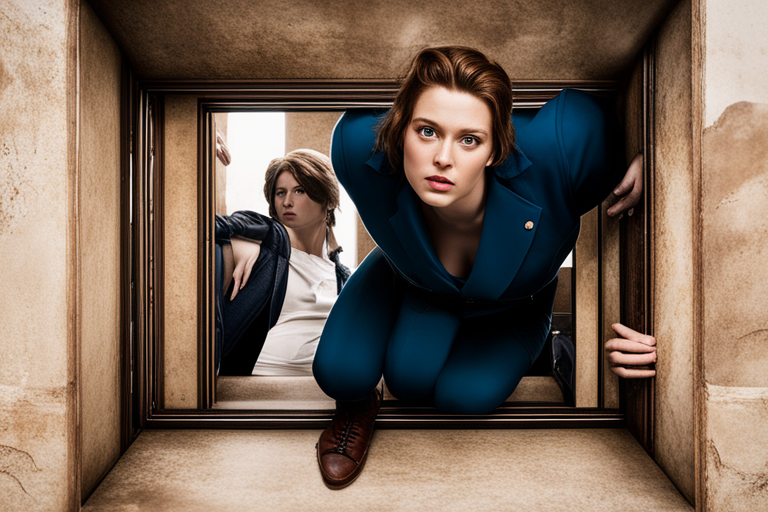

In [76]:
import base64
from PIL import Image
import io

os.makedirs("data", exist_ok=True)
image_1 = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
image_1.save("data/image_1.png")
image_1

Response :  Here is a summary of the story of Little Red Riding Hood:

Little Red Riding Hood lived with her mother in a small house near the forest. One day, her mother asked Little Red Riding Hood to bring some milk, bread, and butter to her sick grandmother who lived in another house in the forest. 

On the way, Little Red Riding Hood met a hungry wolf who asked where she was going. Little Red Riding Hood told the wolf she was bringing food to her sick grandmother. The wolf told Little Red Riding Hood to pick some flowers, while he ran ahead to grandmother's house.

The wolf got to grandmother's house first. He pretended to be Little Red Riding Hood and ate up the grandmother. Then he got into grandmother's bed to wait for Little Red Riding Hood. 

When Little Red Riding Hood arrived, the wolf pretended to be the grandmother. But Little Red Riding Hood noticed the grandmother looked different
success
iVBORw0KGgoAAAANSUhEUgAAAwAAAAIACAIAAAC6lJxtAAAL6GVYSWZNTQAqAAAACAAGAQAABAAAAAEA...

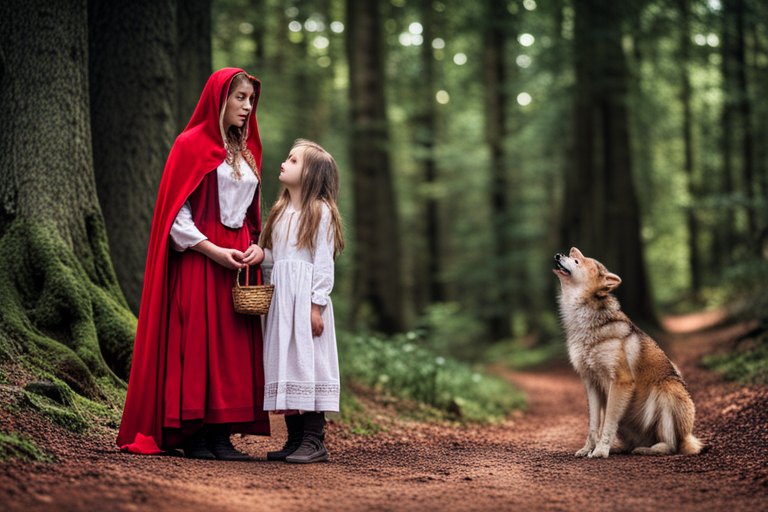

In [89]:
query = "Tell me the story of Little Red Riding Hood"
# vectorstore.similarity_search(query, k=3) 

qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=vectorstore.as_retriever())
results = qa.run(query)

print(f"Response : {results}")


prompt = results
request = json.dumps({
    "text_prompts": (
        [{"text": prompt, "weight": 1.0}]
        + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
    ),
    "cfg_scale": 5,
    "seed": 452345,
    "steps": 60,
    "style_preset": style_preset,
    "clip_guidance_preset": clip_guidance_preset,
    "sampler": sampler,
    "width": width,
})

response = bedrock_client.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

# print(response_body["result"])
base_64_img_str = response_body["artifacts"][0].get("base64")
# print(f"{base_64_img_str[0:80]}...")


image_2 = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
image_2.save("data/image_2.png")
image_2

Response :  Here is a summary of the story of Snow White and the Seven Dwarfs:

Snow White was a beautiful princess who lived with her father, the King, and her stepmother, the wicked Queen. The Queen was very vain and each day she would ask her magic mirror who was the fairest of all. For a long time, the mirror said the Queen was the fairest, but one day it said that Snow White was the fairest. 

The jealous Queen ordered a huntsman to take Snow White to the forest and kill her. But the huntsman took pity on Snow White and told her to run away instead. Snow White fled into the forest and came upon a small cottage belonging to seven dwarfs. While the dwarfs were away, Snow White ate some of their food, then fell asleep in one of their beds. 

When the dwarfs returned home they found Snow White and, after hearing her story, let her stay with them. Snow White kept


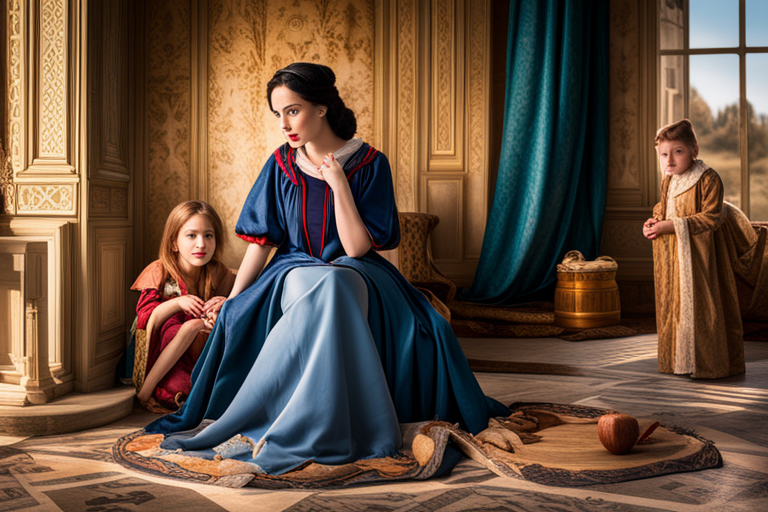

In [90]:
query = "Tell me the story of Snow White and the Seven Dwarfs"
# vectorstore.similarity_search(query, k=3) 

qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=vectorstore.as_retriever())
results = qa.run(query)

print(f"Response : {results}")


prompt = results
request = json.dumps({
    "text_prompts": (
        [{"text": prompt, "weight": 1.0}]
        + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
    ),
    "cfg_scale": 5,
    "seed": 452345,
    "steps": 60,
    "style_preset": style_preset,
    "clip_guidance_preset": clip_guidance_preset,
    "sampler": sampler,
    "width": width,
})

response = bedrock_client.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

# print(response_body["result"])
base_64_img_str = response_body["artifacts"][0].get("base64")
# print(f"{base_64_img_str[0:80]}...")


image_3 = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
image_3.save("data/image_3.png")
image_3

### The response we get this time is generated by our LLM based on the retrieved information from our vector database.

We’re still not entirely protected from convincing yet false hallucinations by the model, they can happen, and it’s unlikely that we can eliminate the problem completely. However, we can do more to improve our trust in the answers provided.

An effective way of doing this is by adding citations to the response, allowing a user to see where the information is coming from. We can do this using a slightly different version of the RetrievalQA chain called RetrievalQAWithSourcesChain.

In [26]:
from langchain.chains import RetrievalQAWithSourcesChain


qa_with_sources = RetrievalQAWithSourcesChain.from_chain_type(
llm=llm, chain_type="stuff", retriever=vectorstore.as_retriever(), return_source_documents=True)

In [27]:
qa_with_sources(query)

{'question': 'How has AWS evolved?',
 'answer': " Based on the provided texts, here are some key points about how AWS has evolved:\n\n- In the early days, some questioned if compute would be an undifferentiated commodity, but AWS has become a much more game-changing offering over time. \n\n- AWS growth also created some short-term logistics and cost challenges that Amazon spent its first 25 years building infrastructure to handle.\n\n- During the COVID-19 pandemic, AWS played a major role in enabling business continuity as companies shifted to remote work. Its ability to quickly scale capacity up and down helped businesses adjust. \n\n- AWS and Amazon's consumer businesses have had different demand trajectories during the pandemic.\n\n- The texts do not provide definitive details on the full evolution of AWS over time.\n\n",
 'sources': '',
 'source_documents': [Document(page_content='a significant differentiator), butalso allowed us to arrive at the much more game-changing offering th

Now we have answered the question being asked but also included the source of this information being used by the LLM.

We’ve learned how to ground Large Language Models with source knowledge by using a vector database as our knowledge base. Using this, we can encourage accuracy in our LLM’s responses, keep source knowledge up to date, and improve trust in our system by providing citations with every answer.

We can use this embedding of the query to then fetch relevant documents.
Now our query is represented as embeddings we can do a similarity search of our query against our data store providing us with the most relevant information.

### Customizable option
In the above scenario you explored the quick and easy way to get a context-aware answer to your question. Now let's have a look at a more customizable option with the helpf of [RetrievalQA](https://python.langchain.com/en/latest/modules/chains/index_examples/vector_db_qa.html) where you can customize how the documents fetched should be added to prompt using `chain_type` parameter. Also, if you want to control how many relevant documents should be retrieved then change the `k` parameter in the cell below to see different outputs. In many scenarios you might want to know which were the source documents that the LLM used to generate the answer, you can get those documents in the output using `return_source_documents` which returns the documents that are added to the context of the LLM prompt. `RetrievalQA` also allows you to provide a custom [prompt template](https://python.langchain.com/en/latest/modules/prompts/prompt_templates/getting_started.html) which can be specific to the model.

Note: In this example we are using Anthropic Claude as the LLM under Amazon Bedrock, this particular model performs best if the inputs are provided under `Human:` and the model is requested to generate an output after `Assistant:`. In the cell below you see an example of how to control the prompt such that the LLM stays grounded and doesn't answer outside the context.

In [28]:
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

prompt_template = """

Human: Use the following pieces of context to provide a concise answer to the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}

Assistant:"""

PROMPT = PromptTemplate(template=prompt_template, input_variables=["context", "question"])

qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": PROMPT},
)
result = qa({"query": query})
print_ww(result["result"])

 Based on the provided context, some key points about how AWS has evolved are:

- AWS started off providing basic compute services but has grown into a much broader offering.

- The growth of AWS created some logistics and cost challenges initially.

- During the pandemic, AWS enabled business continuity by providing the ability to quickly scale
capacity up and down.

- AWS and Amazon's consumer business have had different demand trajectories during the pandemic. AWS
has seen increased demand while the consumer business saw more variable demand.

- Over time, AWS has evolved from a basic compute offering to a broad suite of cloud services that
has played a major role in enabling remote work and business continuity during the pandemic.


In [29]:
result["source_documents"]

[Document(page_content='a significant differentiator), butalso allowed us to arrive at the much more game-changing offering that AWS is today.', metadata={'source': 'AMZN-2021-Shareholder-Letter.pdf', 'year': 2021.0}),
 Document(page_content='This growth also created short-term logistics and cost challenges. We spent Amazon’s first 25 years building', metadata={'source': 'AMZN-2021-Shareholder-Letter.pdf', 'year': 2021.0}),
 Document(page_content='In the early days of AWS, people sometimes asked us why compute wouldn’t just be an undifferentiated', metadata={'source': 'AMZN-2021-Shareholder-Letter.pdf', 'year': 2021.0}),
 Document(page_content='it’s been. Whatever role Amazon played in the world up to that point became further magnified as mostphysical venues shut down for long periods of time and people spent their days at home. This meant thathundreds of millions of people relied on Amazon for PPE, food, clothing, and various other items thathelped them navigate this unprecedented ti

## Conclusion
Congratulations on completing this moduel on retrieval augmented generation! This is an important technique that combines the power of large language models with the precision of retrieval methods. By augmenting generation with relevant retrieved examples, the responses we recieved become more coherent, consistent and grounded. You should feel proud of learning this innovative approach. I'm sure the knowledge you've gained will be very useful for building creative and engaging language generation systems. Well done!

In the above implementation of RAG based Question Answering we have explored the following concepts and how to implement them using Amazon Bedrock and it's LangChain integration.

- Loading documents and generating embeddings to create a vector store
- Retrieving documents to the question
- Preparing a prompt which goes as input to the LLM
- Present an answer in a human friendly manner
- keep source knowledge up to date, and improve trust in our system by providing citations with every answer.

### Take-aways
- Experiment with different Vector Stores
- Leverage various models available under Amazon Bedrock to see alternate outputs
- Explore options such as persistent storage of embeddings and document chunks
- Integration with enterprise data stores

# Thank You